In [ ]:
from diffusers import DiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import DDPMScheduler
import PIL.Image
import numpy as np
import torch

model_dir = "./mm_model"
repo_id = "runwayml/stable-diffusion-v1-5" #pretrained model

In [ ]:
# Load finetuned model from local directory
model = UNet2DConditionModel.from_pretrained(model_dir+"/unet",
                                            safety_checker = None,
                                            requires_safety_checker = False)

# Load text encoder, tokenizer, and scheduler corresponding to the finetuned model
# (in this case I have not trained the text_encoder, because I'm training with DeepSpeed, see: https://github.com/huggingface/accelerate/issues/253#issuecomment-1253231210)
text_encoder = CLIPTextModel.from_pretrained(model_dir+"/text_encoder")
tokenizer = CLIPTokenizer.from_pretrained(model_dir+"/tokenizer")
scheduler = DDPMScheduler.from_config("./mm_model/scheduler")

# Load pretrained model pipeline, passing your finetuned unet
pipeline = DiffusionPipeline.from_pretrained(repo_id,
                                            text_encoder=text_encoder,
                                            unet=model).to("cuda")
#pipeline

/home/diffusers/venv/lib/python3.10/site-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [ ]:
def image_square_crop_resize(path_to_image, size):
    # crops and resizes input images into squares of size = size

    init_image = PIL.Image.open(path_to_image).convert("RGB")
    w, h = init_image.width, init_image.height
    size = min(w, h)  #to convert images into squares
    coords = ((w-size)/2, (h-size)/2, (w+size)/2, (h+size)/2,)
    init_image = init_image.crop(coords)
    init_image = init_image.resize((size, size))
    return init_image


In [ ]:
init_image = image_square_crop_resize("mm/input_images/mm_13.png", 256)
#display(init_image)

## Pipeline inference hyperparameters:

Here we will vary the following parameters:

num_inference_steps: The number of denoising steps. More denoising steps usually lead to a \
higher quality image at the expense of slower inference. This parameter is modulated by strength.

guidance_scale: A higher guidance scale value encourages the model to generate images closely \
linked to the text prompt at the expense of lower image quality. Guidance scale is enabled when guidance_scale > 1.

strength:  Indicates extent to transform the reference image. Must be between 0 and 1. image is used as a \
starting point and more noise is added the higher the strength. The number of denoising steps depends on \
the amount of noise initially added. When strength is 1, added noise is maximum and the denoising process runs \
for the full number of iterations specified in num_inference_steps. A value of 1 essentially ignores image.

see more choices in:
https://huggingface.co/docs/diffusers/en/api/pipelines/stable_diffusion/img2img

  0%|          | 0/90 [00:00<?, ?it/s]

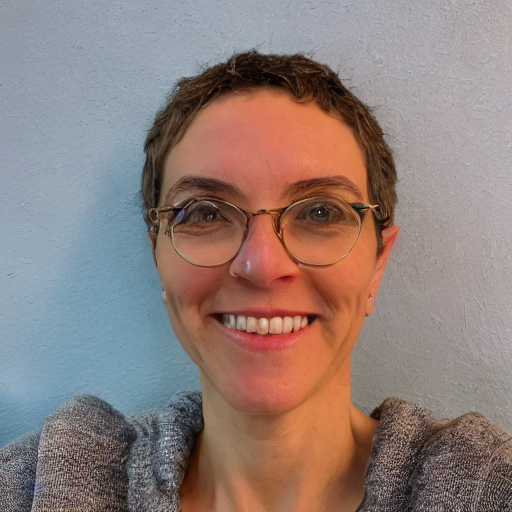

In [ ]:

prompt = "A photo of mfm"
num_inference_steps = 90
guidance_scale = 7
strength=0.001


image = pipeline(prompt, image=init_image, strength=strength, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]

image_title = prompt.lower().replace(" ", "_")+"-"+str(num_inference_steps)+"-"+str(guidance_scale)+"-"+str(strength)
image.save("generated_images/"+image_title+".png")
display(image)